# This is an intro to Document clustering made by refering to 

https://github.com/brandomr/document_cluster

In [15]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [16]:
with open("./data/title_list.txt") as file:
    titles = [line.strip() for line in file]

In [17]:
synopses = []

In [18]:
with open("./data/synopses_list_wiki.txt") as file:
    i = True
    l = ' '
    for line in file:            
        if 'BREAKS HERE Plot' in line:
            synopses.append(l) # append the previously collected lines
            l = ' '
        
        l = l + line.strip()

In [40]:
synopses.append('') # run this 3 times

In [41]:
len(synopses)

100

# Stopwords, stemming, and tokenizing¶

In [20]:
stopwords = nltk.corpus.stopwords.words('english')

In [21]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [22]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [42]:
#  iterate over the list of synopses to create two vocabularies

totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [43]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 162054 items in vocab_frame


In [44]:
print(vocab_frame.head())

     words
plot  plot
edit  edit
edit  edit
edit  edit
on      on


# Tf-idf and document similarity

![title](./images/tf_idf.png)

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 8.58 s, sys: 8 ms, total: 8.59 s
Wall time: 8.6 s
(100, 212)


Vocabulary

In [46]:
terms = tfidf_vectorizer.get_feature_names()

In [28]:
terms

['accept',
 'agre',
 'allow',
 'alon',
 'american',
 'ani',
 'anoth',
 'apart',
 'appear',
 'approach',
 'arm',
 'armi',
 'arrang',
 'arriv',
 'ask',
 'attack',
 'attempt',
 'away',
 'becaus',
 'becom',
 'befor',
 'begin',
 'believ',
 'bodi',
 'bring',
 'car',
 'carri',
 'caus',
 'chang',
 'charg',
 'children',
 'citi',
 'claim',
 'close',
 'come',
 'command',
 'commit',
 'confess',
 'confront',
 'continu',
 'convinc',
 'daughter',
 'day',
 'dead',
 'death',
 'decid',
 'despit',
 'did',
 'die',
 'discov',
 'discuss',
 'doe',
 'drive',
 'dure',
 'encount',
 'end',
 'enter',
 'escap',
 'eventu',
 'explain',
 'face',
 'fail',
 'fall',
 'famili',
 'father',
 'feel',
 'fight',
 'film',
 'final',
 'flee',
 'follow',
 'forc',
 'friend',
 'girl',
 'goe',
 'gun',
 'hand',
 'happen',
 'head',
 'hear',
 'help',
 'hide',
 'hold',
 'home',
 'hope',
 'hous',
 'howev',
 'immedi',
 'includ',
 'inform',
 'initi',
 'insist',
 'instead',
 'invit',
 'job',
 'john',
 'join',
 'just',
 'kill',
 'know',
 'la

Calculate the cosine similarity using the tf_idf matrix
![title](./images/cosine.png)

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

# K-Means Clustering

In [48]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 320 ms, sys: 0 ns, total: 320 ms
Wall time: 322 ms


In [49]:
from sklearn.externals import joblib

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [50]:
with open("./data/genres_list.txt") as file:
    genres = [line.strip() for line in file]

In [51]:
# Couldn't scrap ranks from IMDB
# Therefore, im creating random ranks
import random
ranks = []

for num in range(100):
    ranks.extend(random.sample(range(1, 10), 1))

In [52]:
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

In [53]:
len(clusters)

100

In [54]:
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [55]:
frame['cluster'].value_counts()

4    35
2    23
0    17
1    13
3    12
Name: cluster, dtype: int64

In [56]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: b'father', b'make', b'fight', b'begin', b'refuses', b'night',

Cluster 0 titles: The Shawshank Redemption, Gladiator, Raiders of the Lost Ark, The Best Years of Our Lives,

/home/dhantha/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
/home/dhantha/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


 Braveheart, The French Connection, The King's Speech, Midnight Cowboy, Mr. Smith Goes to Washington, Annie Hall, Out of Africa, The Green Mile, Pulp Fiction, Stagecoach, The Third Man, North by Northwest, Yankee Doodle Dandy,

Cluster 1 words: b'film', b'tells', b'woman', b'story', b'end', b'love',

Cluster 1 titles: Raging Bull, Titanic, Sunset Blvd., Forrest Gump, Singin' in the Rain, Apocalypse Now, To Kill a Mockingbird, A Place in the Sun, Close Encounters of the Third Kind, Network, The Graduate, The Maltese Falcon, Taxi Driver,

Cluster 2 words: b'family', b'new', b'war', b'john', b'york', b'marries',

Cluster 2 titles: The Godfather, Schindler's List, Citizen Kane, The Godfather: Part II, The Sound of Music, It's a Wonderful Life, Some Like It Hot, Rocky, A Streetcar Named Desire, An American in Paris, My Fair Lady, Ben-Hur, The Treasure of the Sierra Madre, Dances with Wolves, The Pianist, City Lights, It Happened One Night, Rain Man, Good Will Hunting, Terms of Endearment, F

# Multidimensional Scaling

In [57]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()


In [58]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

/home/dhantha/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


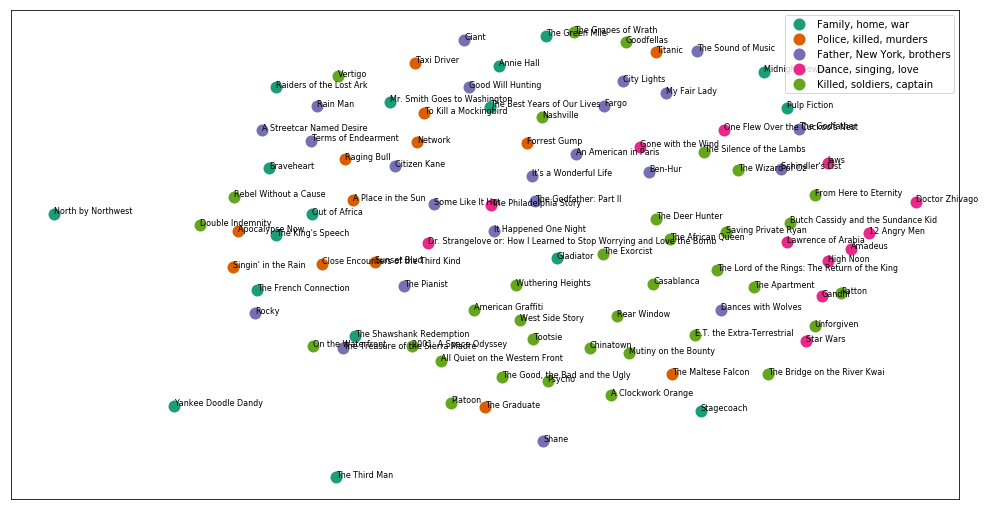

In [59]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [60]:
plt.close()